In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import networkx as nx
from collections import defaultdict
from scipy.optimize import minimize

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.autolayout'] = False
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.markeredgewidth'] = 1.2
mpl.rcParams['errorbar.capsize'] = 5
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 6
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 6
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams['font.family'] = 'sans-serif'
cm_colors = plt.get_cmap('Set2')


In [4]:
def sigmoid(x, k_0, k_1):
    error = x
    return 1 / (1 + k_0 * error**k_1 )

def exponential(x, k_0):
    error = x
    return 2**(-k_0 * error)

def noise_fun(x, probN, errorT):
    k_0 = x[0]
    # prob = np.array([sigmoid(error, k_0, k_1) for error in errorT])
    prob = np.array([exponential(error, k_0) for error in errorT])
    error = np.mean((prob - probN)**2)
    return error 

def noise_model(lambd, N2q, k_0):
    error_acc = lambd * N2q
    prob_r = 1 / (1 + error_acc**k_0 )
    return prob_r

def noise_model_exponential(lambd, N2q, k_0):
    error_acc = lambd * N2q
    prob_r =  np.exp(-k_0 * error_acc)
    return prob_r

def gates_per_overlap(p_r, lambd, k_0, k_1):
    N_2q = ((1/p_r - 1)/k_0)**(1/k_1)/lambd
    return N_2q

def gates_per_overlap_exponential(p_r, lambd, k_0):
    N_2q = np.log(p_r)/(-lambd*k_0)
    return N_2q

def lambda_per_overlap_exponential(p_r, N_2q, k_0):
    lambd = np.log(p_r)/(-N_2q*k_0)
    return lambd

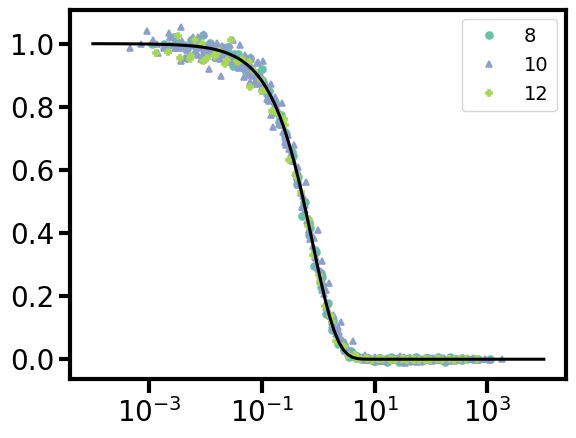

In [8]:
prop = "probabiliy"
colors = plt.get_cmap("Set2")
fig, ax = plt.subplots()
ps = {8:[20,40], 10:[10,20,40], 12:[10]}
nqs = [8, 10, 12]
k_0s = []
markers = {8:"o", 10:"^", 12:"P"}
for nq in nqs:
    for j, p in enumerate(ps[nq]):
        data = np.load(f"./Data/Noise/{nq}_p{p}.npy", allow_pickle=True).item()
        for i, prob in enumerate(data["probs"]):
            probR = data[prob]["noise"][1][prop]
            probN = np.array([(data[prob]["noise"][error][prop] - probR)/(data[prob]["ideal"][prop] - probR) for error in data["errors"]])
            errorT = data["errors"]*prob*p*nq*(nq-1)/2
            x0 = [1.25]
            sol = minimize(noise_fun, x0, args=(probN, errorT), method="Nelder-Mead")
            k_0s.append(sol.x[0])
            # print(f"nq: {nq} | p: {p} | prob: {prob} | x: {sol.x} |  error: {sol.fun}")
            ax.plot(errorT, probN, color=colors(nq-8), marker=markers[nq], linewidth=0)
    ax.plot([],[], label=nq, color = colors(nq-8), linewidth=0, marker=markers[nq])
k_0 = np.mean(k_0s)
errorT = np.logspace(np.log10(1e-4), np.log10(1e4), num=100)
# ax.plot(errorT, [sigmoid(error, k_0, k_1) for error in errorT], color="black")
ax.plot(errorT, [exponential(error, k_0) for error in errorT], color="black")

ax.legend()
ax.set_xscale("log")
fig.savefig("./Figures/error_T.pdf", bbox_inches="tight", transparent=True)
# ax.set_xlabel(r"$log(N_{edges} p \epsilon)$")
# ax.set_ylabel(r"$\frac{(p^{n}_{gs}-p_{r})}{(p^{i}_{gs}-p_{r})}$", rotation=0)


In [9]:
k_0

np.float64(1.8213330078125)

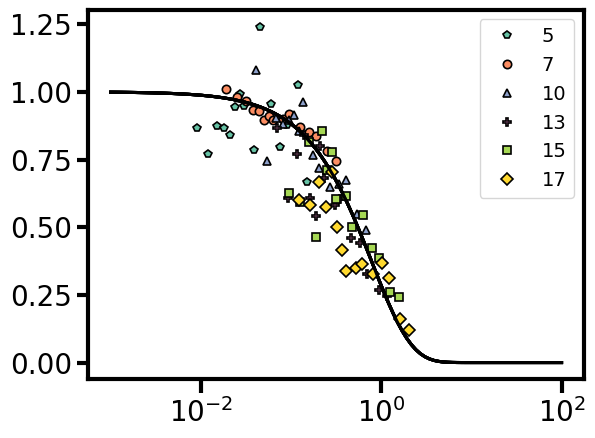

In [252]:
fig, ax = plt.subplots()
markers = {5:"p", 7:"o", 10:"^", 13:"P", 15:"s", 17:"D"}
for ii, nq in enumerate([5,7,10,13,15,17]):
    res = np.load(f"./Data/H1-1E/{nq}_FC.npy", allow_pickle=True).item()
    ideal = np.load(f"./Data/qasm_simulator/{nq}_FC.npy", allow_pickle=True).item()
    ps = res["ps"]
    pn = np.array([res["postprocessing"][res['Deltas'][0]][p][0]["probability"] for p in ps])
    pi =  np.array([ideal["postprocessing"][res['Deltas'][0]][p][0]["probability"] for p in ps])
    pr =  np.array(res["random"]["probability"])
    p = (pn - pr)/(pi - pr)
    Nedges = nq*(nq-1)/2
    error = 3e-4
    errorT = Nedges * error * np.array(ps)
    ax.plot(errorT, p, linewidth=0, markersize=6, markeredgecolor="black", label=nq, marker=markers[nq], color=colors(ii))
    ax.set_xscale("log")
    errorT = np.logspace(np.log10(1e-3), np.log10(1e2), num=100)  
    # ax.plot(errorT, [sigmoid(error, k_0, k_1) for error in errorT], color="black")
    ax.plot(errorT, [exponential(error, k_0) for error in errorT], color="black")

ax.legend()
fig.savefig("./Figures/error_H1-1E.pdf", bbox_inches="tight", transparent=True)


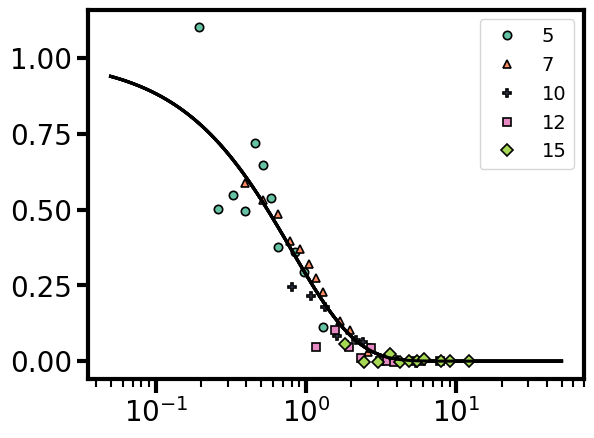

In [254]:
fig, ax = plt.subplots()
markers = {5:"o", 7:"^", 10:"P", 12:"s", 15:"D",17:"p"}
for ii, nq in enumerate([5,7,10,12,15]):
    res = np.load(f"/Users/alejomonbar/Documents/GitHub/FC-LR-QAOA-Benchmarking/Data/ibm_fez/{nq}_FC_1DParityBench_1.npy", allow_pickle=True).item()
    ideal = np.load(f"./Data/qasm_simulator/{nq}_FC.npy", allow_pickle=True).item()
    ps = res["ps"]
    pn = np.array([res["postprocessing"][res['Deltas'][0]][p][0]["probability"] for p in ps])
    pi =  np.array([ideal["postprocessing"][res['Deltas'][0]][p][0]["probability"] for p in ps])
    pr =  np.array(res["random"]["probability"])
    p = (pn - pr)/(pi - pr)
    Nedges = nq*nq-1
    error = 27e-4
    errorT = Nedges * error * np.array(ps)
    ax.plot(errorT, p, linewidth=0, markersize=6, markeredgecolor="black", label=nq, marker=markers[nq], color=colors(ii))
    ax.set_xscale("log")
    errorT = np.logspace(np.log10(5e-2), np.log10(5e1), num=100)  
    ax.plot(errorT, [exponential(error, k_0) for error in errorT], color="black")
ax.legend()
# ax.set_yscale("log")
fig.savefig("./Figures/error_ibm_fez.pdf", bbox_inches="tight", transparent=True)

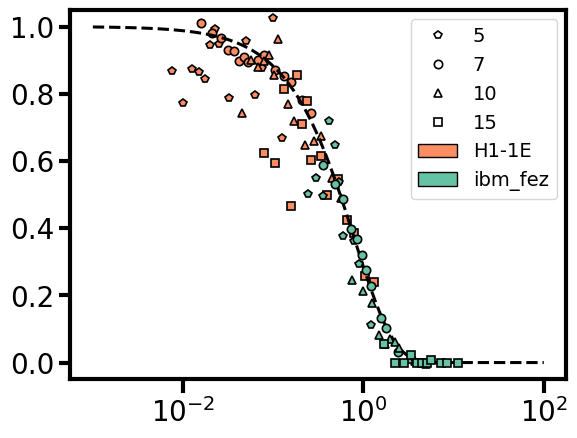

In [283]:
fig, ax = plt.subplots()
markers = {5:"p", 7:"o", 10:"^", 12:"P", 15:"s"}
for ii, nq in enumerate([5,7,10,15]):
    res = np.load(f"./Data/H1-1E/{nq}_FC.npy", allow_pickle=True).item()
    ideal = np.load(f"./Data/qasm_simulator/{nq}_FC.npy", allow_pickle=True).item()
    ps = res["ps"]
    pn = np.array([res["postprocessing"][res['Deltas'][0]][p][0]["probability"] for p in ps])
    pi =  np.array([ideal["postprocessing"][res['Deltas'][0]][p][0]["probability"] for p in ps])
    pr =  np.array(res["random"]["probability"])
    p = (pn - 2/2**nq)/(pi - 2/2**nq)
    Nedges = nq*(nq-1)/2
    error = 2.5e-4
    errorT = Nedges * error * np.array(ps)
    ax.plot(errorT, p, linewidth=0, markersize=6, markeredgecolor="black", marker=markers[nq], color=colors(1))
    ax.plot([], [], linewidth=0, markersize=6, markeredgecolor="black", label=nq, marker=markers[nq], color="white")
errorT = np.logspace(np.log10(1e-3), np.log10(1e2), num=100)  
ax.plot(errorT, [exponential(error, k_0) for error in errorT], color="black", linestyle="--")
for ii, nq in enumerate([5,7,10,15]):
    res = np.load(f"/Users/alejomonbar/Documents/GitHub/FC-LR-QAOA-Benchmarking/Data/ibm_fez/{nq}_FC_1DParityBench_1.npy", allow_pickle=True).item()
    ideal = np.load(f"./Data/qasm_simulator/{nq}_FC.npy", allow_pickle=True).item()
    ps = res["ps"]
    pn = np.array([res["postprocessing"][res['Deltas'][0]][p][0]["probability"] for p in ps])
    pi =  np.array([ideal["postprocessing"][res['Deltas'][0]][p][0]["probability"] for p in ps])
    pr =  np.array(res["random"]["probability"])
    p = (pn - pr)/(pi - pr)
    Nedges = nq*nq-1
    error = 25e-4
    errorT = Nedges * error * np.array(ps)
    ax.plot(errorT, p, linewidth=0, markersize=6, markeredgecolor="black", marker=markers[nq], color=colors(0))
# for ii, nq in enumerate([10,15]):
#     res = np.load(f"/Users/alejomonbar/Documents/GitHub/Benchmarking-LR-QAOA/Data/ionq_aria_2/{nq}_FC.npy", allow_pickle=True).item()
#     ideal = np.load(f"./Data/qasm_simulator/{nq}_FC.npy", allow_pickle=True).item()
#     ps = res["ps"]
#     pn = np.array([res["postprocessing"][res['Deltas'][0]][p][0]["probability"] for p in ps])
#     pi =  np.array([ideal["postprocessing"][res['Deltas'][0]][p][0]["probability"] for p in ps])
#     pr =  np.array(res["random"]["probability"])
#     p = (pn - pr)/(pi - pr)
#     Nedges = nq*(nq-1)/2
#     error = 20e-4
#     errorT = Nedges * error * np.array(ps)
#     ax.plot(errorT, p, linewidth=0, markersize=6, markeredgecolor="black", marker=markers[nq], color=colors(3))
ax.set_xscale("log")
ax.fill_between([],[],[], color=colors(1),edgecolor="black", label="H1-1E")
ax.fill_between([],[],[], color=colors(0),edgecolor="black", label="ibm_fez")
ax.legend()
ax.set_ylim(-0.05, 1.05)
fig.savefig("./Figures/error_H1-1E_ibm_fez.pdf", bbox_inches="tight", transparent=True)

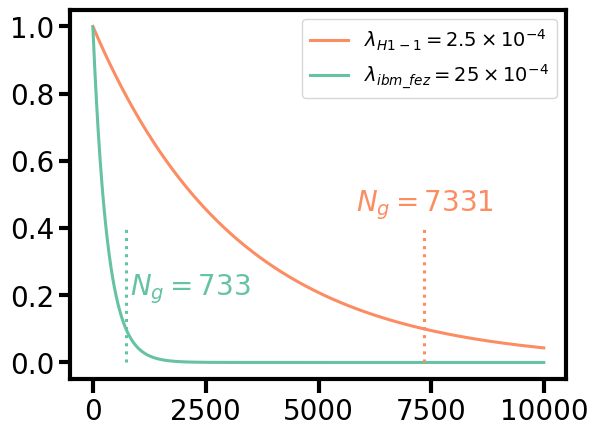

In [295]:
fig, ax = plt.subplots()
N_2q = np.arange(1, 10_000, 10)
lambda_1 = 2.5e-4
lambda_2 = 25e-4
# lambda_3 = 1e-5
y1 = noise_model_exponential(lambda_1, N_2q, k_0)
y2 = noise_model_exponential(lambda_2, N_2q, k_0)
# y3 = noise_model_exponential(lambda_3, N_2q, k_0)

ax.plot(N_2q, y1, color=colors(1), label=r"$\lambda_{H1-1} = 2.5\times10^{-4}$")
ax.plot(N_2q, y2, color=colors(0), label=r"$\lambda_{ibm\_fez} = 25\times10^{-4}$")
# ax.plot(N_2q, y3, color="black", label=r"$\lambda_{ionq} = 1\times10^{-5}$")
N_2q_1 = round(gates_per_overlap_exponential(0.1, lambda_1, k_0))
ax.vlines(N_2q_1, 0, 0.4, color=colors(1), linestyle=":")
ax.text(N_2q_1-1500, 0.45, r"$N_{g} = $" +f"{N_2q_1}", color=colors(1), fontsize=20)
N_2q_2 = round(gates_per_overlap_exponential(0.1, lambda_2, k_0))
ax.text(N_2q_2+100, 0.2, r"$N_{g} = $" +f"{N_2q_2}", color=colors(0), fontsize=20)
ax.vlines(N_2q_2, 0, 0.4, color=colors(0), linestyle=":")
# N_2q_3 = round(gates_per_overlap_exponential(0.1, lambda_3, k_0, k_1))
# ax.text(N_2q_3-1500, 0.45, r"$N_{2q} = $" +f"{N_2q_3}", color="black", fontsize=20)
# ax.vlines(N_2q_3-1500, 0, 0.45, color="black", linestyle=":")
ax.legend()
# ax.set_xscale("log")
fig.savefig("./Figures/pr_vs_N2q_real.pdf", bbox_inches="tight", transparent=True)


In [257]:
k_0

np.float64(1.256439208984375)

In [279]:
N_2q = 1_000_000
lambda_per_overlap_exponential(0.1, N_2q, k_0)

np.float64(1.8326275370340502e-06)

In [294]:
gates_per_overlap_exponential(0.1, 2.5e-5, k_0)

np.float64(73305.10148136201)